In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('text_emotion.csv')

## Data Understanding and Preprocessing

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8638.0,0.215950
worry,8459.0,0.211475
happiness,5209.0,0.130225
sadness,5165.0,0.129125
love,3842.0,0.096050
surprise,2187.0,0.054675
fun,1776.0,0.044400
relief,1526.0,0.038150
hate,1323.0,0.033075
empty,827.0,0.020675


There are no empty rows 

Lets see the group of sentiments on a graph

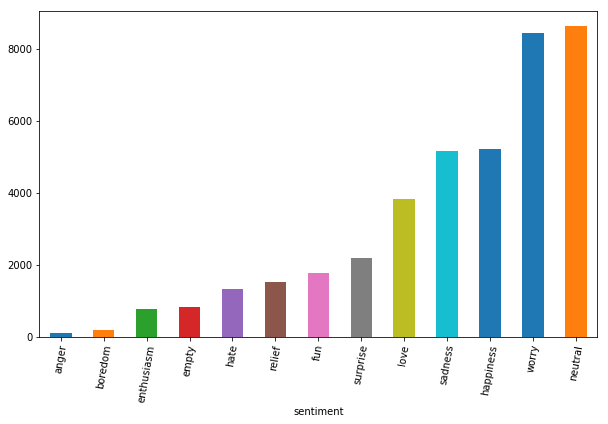

In [6]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [7]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [8]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [9]:
df.content.duplicated().sum()

173

It looks like there are duplicated tweets (which could be retweets maybe) that needs to be taken into consideration

In [10]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9                                14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                                                 13
Happy Mother's Day!                                                                                                                         10
Happy Mothers Day                                                                                                                           10
happy mother's day                                                                                                                           8
http://snipurl.com/hq0n1 Just printed my mom an Amazon gift card  for Happy Mothers Day talk about last minute.                              7
Good Morning                                                                                                                                 6

In [11]:
df[df.content=='happy mothers day']

,tweet_id,sentiment,author,content
29348,1751177832,love,jadeeisabel,happy mothers day
36768,1753366853,love,janethglz,happy mothers day
36819,1753381594,happiness,bree_gee,happy mothers day
37340,1753468050,love,starbuckscup,happy mothers day
39131,1753773088,neutral,vwebling,happy mothers day


For the same tweet there are different sentiments in the sentiment column. I decided to drop these duplicates and different labels

In [53]:
df=df.drop_duplicates(subset='content')

In [54]:
df.content.duplicated().sum()

0

Now lets see the distribution of emotions in the data set

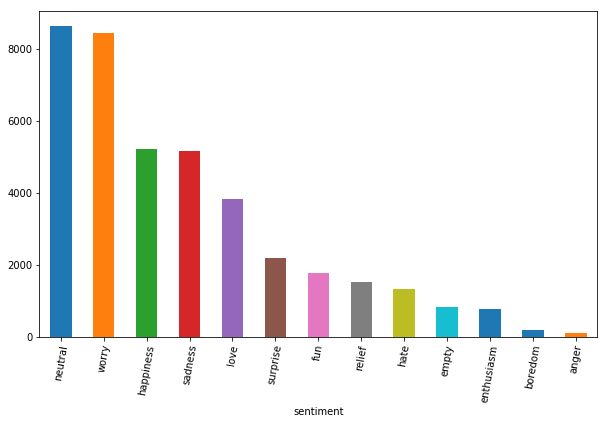

In [13]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [14]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [15]:
spacy_tok = spacy.load('en')
sample_review=df.content[8]
sample_review

'@charviray Charlene my love. I miss you'

In [16]:
parsed_review = spacy_tok(sample_review)
parsed_review

@charviray Charlene my love. I miss you

It looks like there are some html characters within the text such as:‘&amp’,’&quot’,etc. For decoding html to general text, beautiful soup can be used

In [17]:




wordpunctok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'

combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        quotRem = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        quotRem = souped
    stripped = re.sub(combined_pat, '', quotRem)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    words = [x for x  in wordpunctok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


df['Cleaned'] = df.content.apply(tweet_cleaner)

For removing the white spaces after the cleaning, i joined the letters with white spaces

In [18]:
df.Cleaned.head(10)

0                                             know was listenin to bad habit earlier and started freakin at his part
1                                                                 layin bed with headache ughhhh waitin on your call
2                                                                                     funeral ceremony gloomy friday
3                                                                                wants to hang out with friends soon
4                                              we want to trade with someone who has houston tickets but no one will
5                                             re pinging why did not you go to prom bc my bf did not like my friends
6    should be sleep but im not thinking about an old friend who want but he married now damn he wants me scandalous
7                                                                                                       hmmm is down
8                                                               

In [19]:
df.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know was listenin to bad habit earlier and started freakin at his part
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed with headache ughhhh waitin on your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",we want to trade with someone who has houston tickets but no one will


In [20]:

english_stops = set(stopwords.words('english'))

lemmatizer=WordNetLemmatizer()
stopword_list= stopwords.words('english')

df['Cleaned'] = df['Cleaned'].\
apply(lambda x: [lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if k not in stopword_list]]).\
apply(lambda x: " ".join(x))

In [21]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.25, random_state=53)

In [22]:
count_vect2 = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train2 = count_vect2.fit_transform(X_train2)
count_vect_train2 = count_vect_train2.toarray()
count_vect_test2 = count_vect2.transform(X_test2)
count_vect_test2 = count_vect_test2.toarray()

In [23]:
logreg_CV2 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV2.fit(count_vect_train2, y_train2)
y_pred_lr_CV2 = logreg_CV2.predict(count_vect_test2)
print('Accuracy :', metrics.accuracy_score(y_test2, y_pred_lr_CV2))

Accuracy : 0.2198


Because of the feuture distribution of the sample, we were expecting a low accuracy in our model. In order to balance the distribution, we can update the categorization of the emotions.

We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [24]:
dfnew=df.copy()

In [25]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [26]:
dfnew.head(20)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday


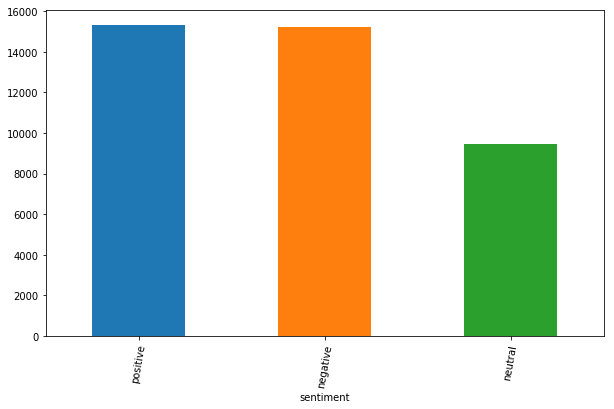

In [27]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [28]:

english_stops = set(stopwords.words('english'))

lemmatizer=WordNetLemmatizer()
stopword_list= stopwords.words('english')

dfnew['Cleaned'] = dfnew['Cleaned'].\
apply(lambda x: [lemmatizer.lemmatize(a) for a in 
                            [k for k in [l for l in [t.lower() for t in word_tokenize(x)] 
                                         if l.isalpha()] if k not in stopword_list]]).\
apply(lambda x: " ".join(x))

In [29]:
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one


## Train-Test Split

In [30]:

X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [31]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [32]:
vocab = count_vect.get_feature_names()

In [33]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,able,absolutely,account,actually,add,afternoon,age,ago,agree,ah,...,yes,yesterday,yet,yo,young,youtube,yr,yum,yummy,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [34]:

logreg_CV = LogisticRegression(random_state=0)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.5751


##  Linear SVC

In [35]:

Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5733

## Naive Bayes

In [36]:

from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(count_vect_train, y_train)

pred = nb_classifier.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.5431

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.5398


## Tf-idf Vectorization¶

In [38]:
tfidf_vect = TfidfVectorizer(min_df=0, max_df=1, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)

print('Longest word:', max(tfidf_vect.vocabulary_, key=len))

Longest word: wooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


## Logreg after Tf-idf

In [39]:
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.3799
              precision    recall  f1-score   support

    negative       0.44      0.07      0.13      3829
     neutral       0.25      0.04      0.07      2389
    positive       0.38      0.91      0.54      3782

   micro avg       0.38      0.38      0.38     10000
   macro avg       0.36      0.34      0.24     10000
weighted avg       0.37      0.38      0.27     10000



## Cross Validation

In [40]:
from sklearn.model_selection import cross_val_score
cvresult = cross_val_score(logreg_CV, count_vect_train, y_train,cv=5)

print(cvresult)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

[0.57164279 0.56707215 0.5705951  0.57559593 0.57009502]


## Lets try NLTK Vader for sentiment comparison

In [41]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [42]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [43]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [44]:
dfnew.head(30)

,tweet_id,sentiment,author,content,Cleaned,vader,compound
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang friend soon,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [45]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(30)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1956967341,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,know listenin bad habit earlier started freakin part,neutral,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin bed headache ughhhh waitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,czareaquino,wants to hang out with friends SOON!,want hang friend soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",want trade someone houston ticket one,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,pinging go prom bc bf like friend,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking old friend want married damn want scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [46]:
for i in dfnew.index[0:30]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[ {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}
1
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
3
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
4
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
5
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
6
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
7
Hmmm. http://www.dj

Let's compare the sentiments in our data and the 'Vader' results

In [47]:
(dfnew.sentiment==dfnew.vader).mean()

0.543225

In [57]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(20)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
19685,1966325761,Dcriptide,"@SamsaTSP Nintendo is the cause, but no news when it's coming out",nintendo cause news coming,neutral,negative,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'compound': -0.4215}"
14903,1964677795,DarrenRuane,@cocotteloup Awww... It works ok for me.. but I have an apple laptop so it might be a little difference!!,work ok apple laptop might little difference,neutral,positive,"{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'compound': 0.2924}"
39473,1753822376,Orchidflower,"Hello all my new followers, there is suddenly a lot of you, so will take a little time to get round to you all",hello new follower suddenly lot take little time get round,positive,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
38937,1753742755,x_tara,@andyclemmensen whens the sway sway winner announced?,whens sway sway winner announced,neutral,positive,"{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.5859}"
36065,1753236833,MissxMarisa,@MeMinty Yeah it's afireinside687,yeah afireinside,neutral,positive,"{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.296}"
8606,1962231862,jm_ch,Thinking about opening MacMaze sources as I don't have time to work on it anymore,thinking opening macmaze source time work anymore,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
9532,1962604819,melissasmission,@danielfelice look like i can only quick post from the dashboard that is all,look like quick post dashboard,neutral,positive,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}"
6326,1961226373,ephaw,@channisaulfah Not even better than Kapsel cha Dy nulis notes? Spertinya gw ga ditag cuz g ada notificationnya... Huhu.,even better kapsel cha dy nulis note spertinya gw ga ditag cuz ada notificationnya huhu,positive,negative,"{'neg': 0.124, 'neu': 0.876, 'pos': 0.0, 'compound': -0.3412}"
18295,1965933233,Jamoo1987,"has just finished reading Twilight and thought it was crap...okay, it was alright...okay, i love it and really wanna read the next one",finished reading twilight thought crap okay alright okay love really wan na read next one,negative,positive,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.6369}"
4068,1960199499,tonyg2388,"@hellocuppycake yeah, guess we gotta wait til sometime in June",yeah guess got ta wait til sometime june,neutral,positive,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.296}"


0